<a href="https://colab.research.google.com/github/riuls/an2dl_challenge_1/blob/luis/Mobilenet_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge
#%cd /gdrive/MyDrive/Deep Learning Challenge/an2dl_challenge_1/an2dl_challenge_1

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
seed = 25

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Utils Functions

In [ ]:
def load_data(folder="public_data.npz", resolution=96, head_only=False):
    images = []

    loaded = np.load(folder, allow_pickle=True)

    # Iterate through files in the specified folder
    for i, img in enumerate(loaded['data']):
        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        #img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        #img = tfkl.Resizing(224, 224)(img)
        img = tfkl.Resizing(resolution, resolution)(img)

        if img is not None:
            images.append(img)

        if (head_only and i == 9):
           break

    labels = loaded['labels']
    loaded.close()

    if (head_only):
       labels = labels[:10]

    y = LabelEncoder().fit_transform(labels)
    #y = tfk.utils.to_categorical(y, 2)

    return np.array(images), y

def display_random_images(X, y, num_img=10):
  # Create subplots for displaying items
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      image = random.randint(0, X.shape[0] - 1)

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def delete_outliers(X, y):
  shrek = 137
  trololo = 5143

  new_X = []
  new_y = []

  num_outliers = 0

  for i, sample in enumerate(X):
    if (not (np.array_equal(sample, X[shrek]) or np.array_equal(sample, X[trololo]))):
      new_X.append(sample)
      new_y.append(y[i])
    else:
      num_outliers += 1

  return np.array(new_X), np.array(new_y), num_outliers


def plot_history(history, name, patience=20):
    plt.figure(figsize=(11,5))
    plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_accuracy'], label='Val Accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_precision'], label='Val Precision', alpha=.8, color='red')
    plt.plot(history['val_recall'], label='Val Recall', alpha=.8, color='blue')
    plt.legend(loc='upper left')
    plt.title(name + ' Accuracy')
    plt.grid(alpha=.3)

    plt.text(0.5, -0.1, 'Train accuracy: ' + str(round(history['accuracy'][-patience-1], 4)) + ', Val accuracy: ' + str(round(np.max(history['val_accuracy']), 4)), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.figure(figsize=(11,5))
    plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
    plt.plot(history['val_loss'], label='Val', alpha=.8, color='#ff7f0e')
    plt.legend(loc='upper left')
    plt.title('Categorical Crossentropy')
    plt.grid(alpha=.3)

    plt.show()

#### Data Loading end preparation

In [ ]:
X, y = load_data('public_data.npz')
X, y, num_outliers = delete_outliers(X, y)

In [ ]:
# Split data into train_val and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=500, stratify=y, random_state=seed)

# Further split train_val into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=500, stratify=np.argmax(y_train_val,axis=1))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4504, 96, 96, 3) (4504,)
(500, 96, 96, 3) (500,)


In [ ]:
def augment_dataset1(X, y):
  augment1 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomTranslation(height_factor = (-0.2,0.2), width_factor = (-0.2,0.2), fill_mode = 'reflect'),
      tfkl.RandomZoom(0.3, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
  ])

  augment2 = tf.keras.Sequential([
      tfkl.RandomFlip(),
      tfkl.RandomZoom(0.4, fill_mode = 'reflect'),
      tfkl.RandomBrightness(0.1, value_range=(0,1)),
      tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
  ])

  new_X_train_1 = augment2(X[y == 1])
  augmented_X_train_2 = augment2(X)
  augmented_X_train_1 = augment1(augmented_X_train_2)

  X = np.append(X, augmented_X_train_2, axis = 0)
  X = np.append(X, augmented_X_train_1, axis = 0)
  X = np.append(X, new_X_train_1, axis = 0)

  y_tmp = np.append(y, y)
  y = np.append(y_tmp, y)
  for k in range(new_X_train_1.shape[0]):
      y = np.append(y, 1)
  return X, y

def augment_dataset(X, y, multiply=1):
  augmentation = tf.keras.Sequential([
      tfkl.RandomRotation((-1, 1), fill_mode = 'reflect'),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tfkl.RandomBrightness((-0.3, 0.1), value_range=(0,1)),
  ])

  X_tmp = X[y == 1]
  for i in range(multiply):
    X = np.append(X, augmentation(X), axis=0)
  X = np.append(X, augmentation(X_tmp), axis=0)

  for i in range(multiply):
    y = np.append(y, y)
  y = np.append(y, np.ones(len(X_tmp)))

  return X, y

In [ ]:
X_train, y_train = augment_dataset(X_train_0, y_train_0)
#X_train, y_train = X_train_0, y_train_0

#Shuffle the dataset
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model  # Output shape for the model
batch_size = 16                # Batch size for training, always a power of 2!!
epochs = 400

print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(10721, 96, 96, 3)
(10721,)
(array([0., 1.]), array([5582, 5139]))


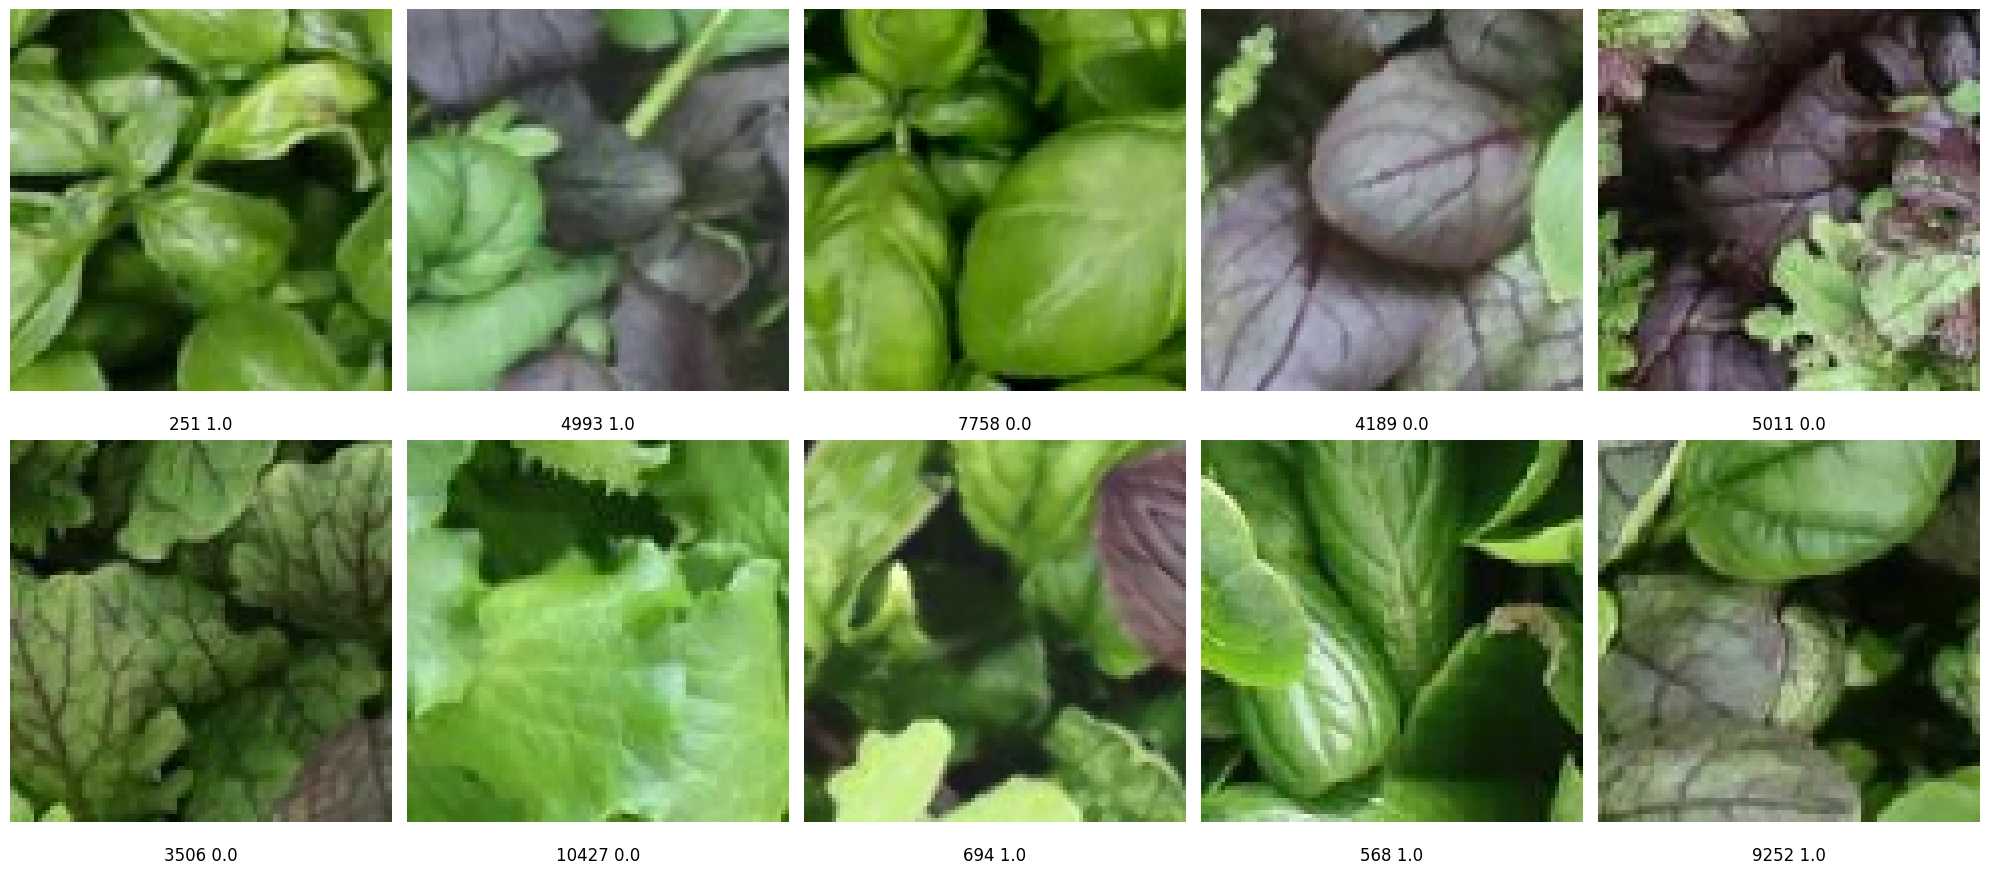

In [ ]:
display_random_images(X_train, y_train)

#### Model building and validation

In [ ]:
def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, learning_rate=1e-4, neurons=[], base_dropout=0, dropout=0, batch_normalization=False, name="model", weight_decay=3e-5):
  mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
  )

  mobile.trainable = False
  inputs = tfk.Input(shape=input_shape)
  # Connect MobileNetV2 to the input
  x = mobile(inputs)
  #x = tfkl.Dropout(base_dropout)(x)

  for n in neurons:
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropout)

  # Add a Dense layer with 2 units and softmax activation as the classifier
  outputs = tfkl.Dense(1, activation='sigmoid')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=['accuracy', tfk.metrics.Precision(name="precision"), tfk.metrics.Recall(name="recall")])

  # Display model summary
  model.summary()

  return model

In [ ]:
input_shape=X_train.shape[1:]
print(input_shape)

(96, 96, 3)


In [ ]:
model_1 = build_model(input_shape)
history = model_1.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 400,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.9, patience = 8, min_lr = 2e-6)
    ]
).history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Epoch 1/400
282/282 [==============================] - 9s 16ms/step - loss: 0.6650 - accuracy: 0.6197 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6672 - val_accuracy: 0.6200 - val_precision: 0.0000e+00 - v

In [ ]:
y_val = y_val.reshape(500,1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


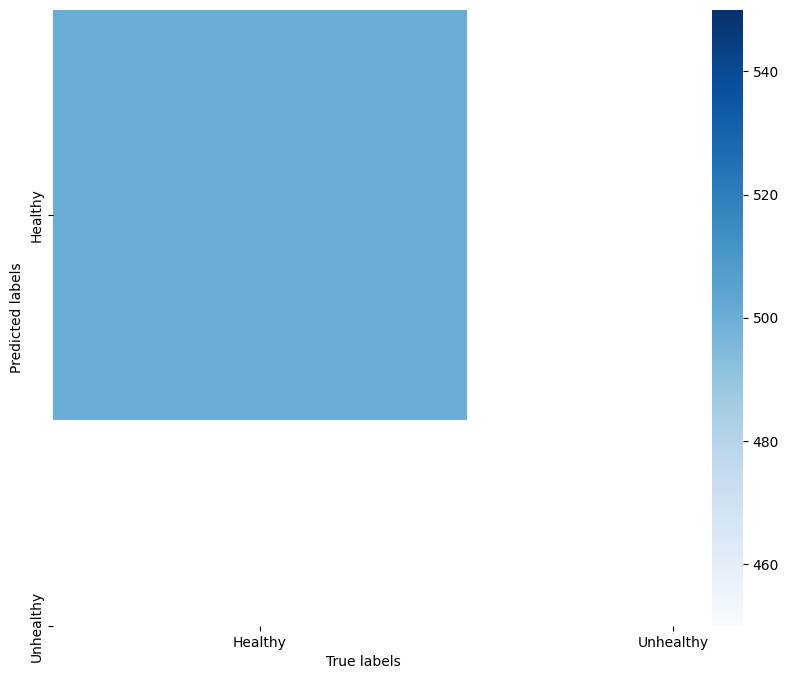

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Predict labels for the entire test set
predictions = model_1.predict(X_val, verbose=0)

# Define a mapping of labels to their corresponding digit names
labels = {0:'Healthy', 1:'Unhealthy'}

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_val), axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(np.array(y_val), axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(np.array(y_val), axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(np.array(y_val), axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(np.array(y_val), axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

16/16 [==============================] - 0s 19ms/step
0.5
1


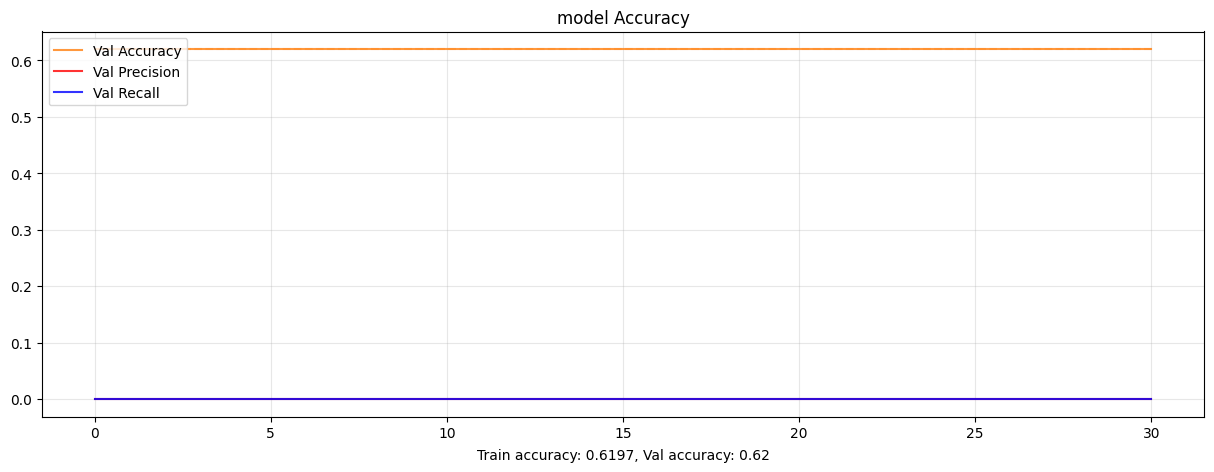

In [ ]:
patience=30

predictions = model_1.predict(X_val)
predictions = (predictions > 0.5).astype("int32")
fpr, tpr, thresholds = roc_curve(y_val, predictions)
roc_auc = auc(fpr, tpr)
#print(classification_report(y_val, predictions))
print(roc_auc)
print(len(history['val_accuracy']) - patience)
plot_history(history, model_1.name)



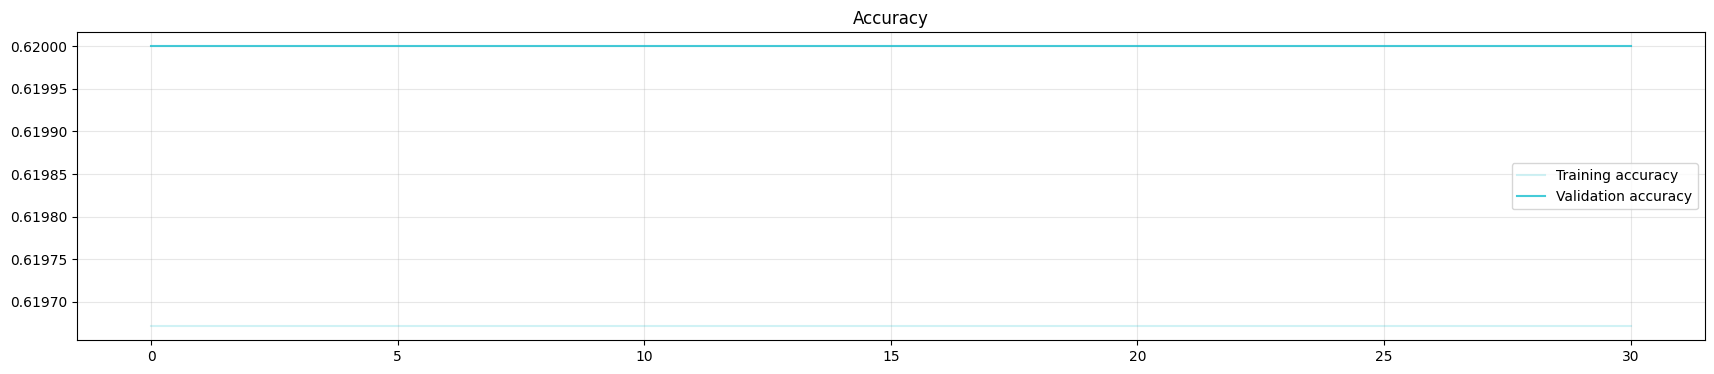

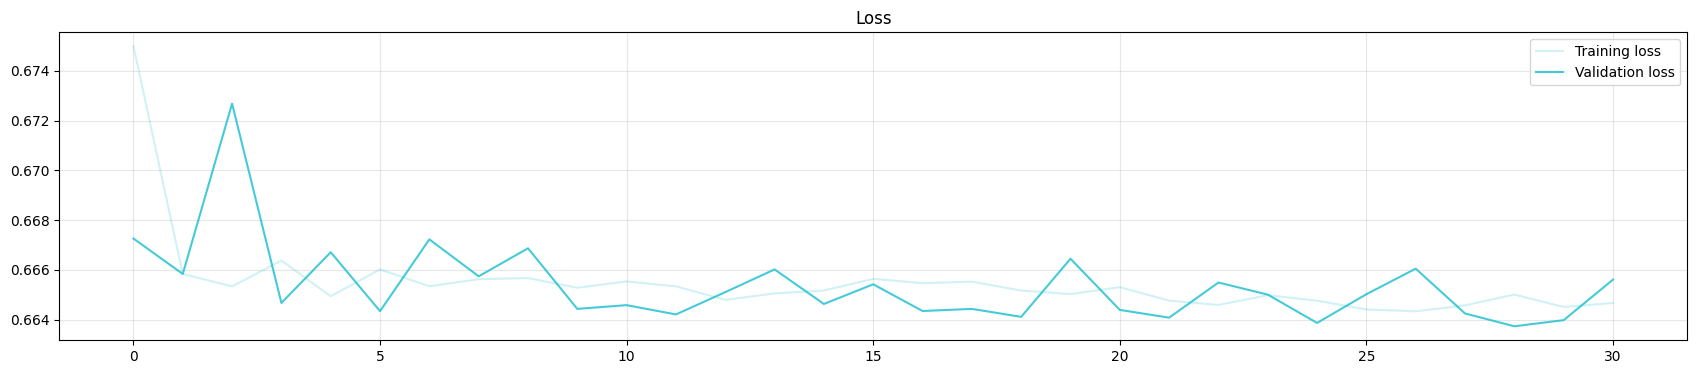

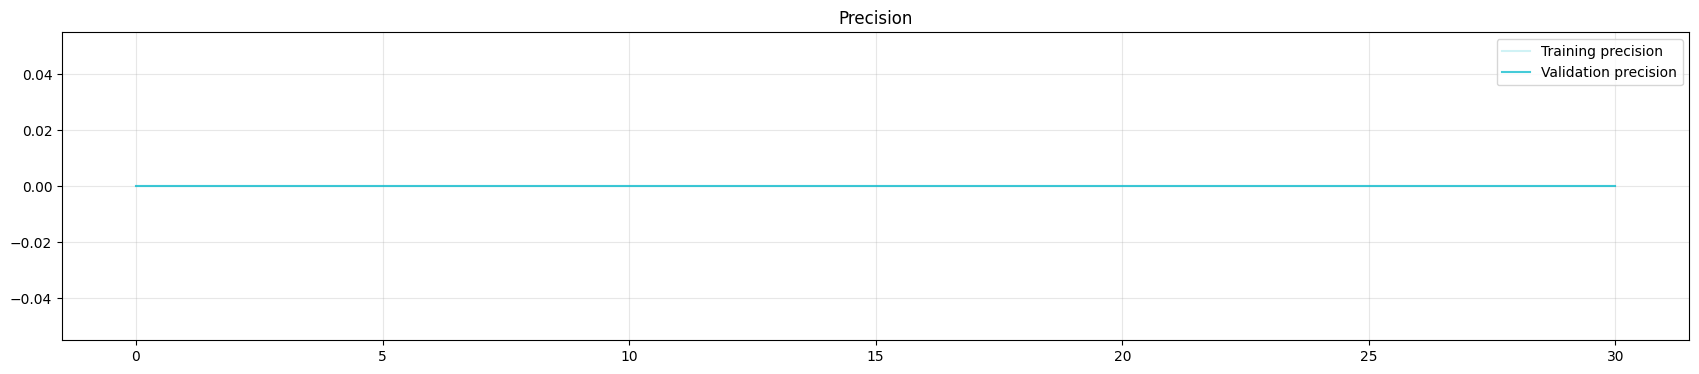

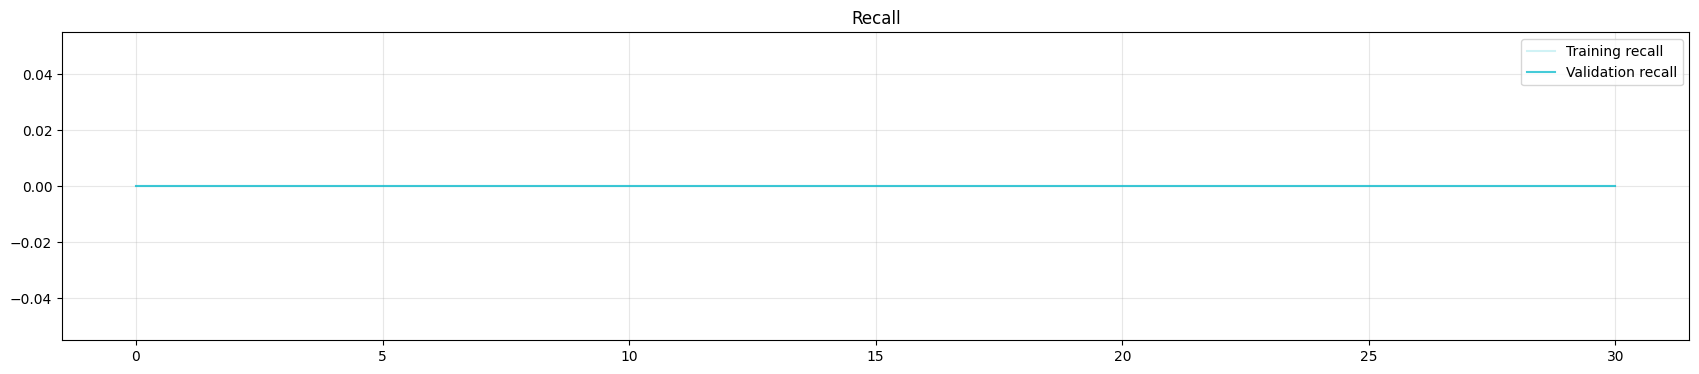

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Set the number of initial data points to ignore
ignore = 0

# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['accuracy'][ignore:], label='Training accuracy', alpha=.2, color='#17becf')
plt.plot(history['val_accuracy'][ignore:], label='Validation accuracy', alpha=.8, color='#17becf')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)


# Set the number of initial data points to ignore
ignore = 0

# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['loss'][ignore:], label='Training loss', alpha=.2, color='#17becf')
plt.plot(history['val_loss'][ignore:], label='Validation loss', alpha=.8, color='#17becf')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Set the number of initial data points to ignore
ignore = 0

# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['precision'][ignore:], label='Training precision', alpha=.2, color='#17becf')
plt.plot(history['val_precision'][ignore:], label='Validation precision', alpha=.8, color='#17becf')
plt.title('Precision')
plt.legend()
plt.grid(alpha=.3)

# Set the number of initial data points to ignore
ignore = 0

# Create a figure for loss visualization
plt.figure(figsize=(21, 4))

# Plot training and validation loss
plt.plot(history['recall'][ignore:], label='Training recall', alpha=.2, color='#17becf')
plt.plot(history['val_recall'][ignore:], label='Validation recall', alpha=.8, color='#17becf')
plt.title('Recall')
plt.legend()
plt.grid(alpha=.3)

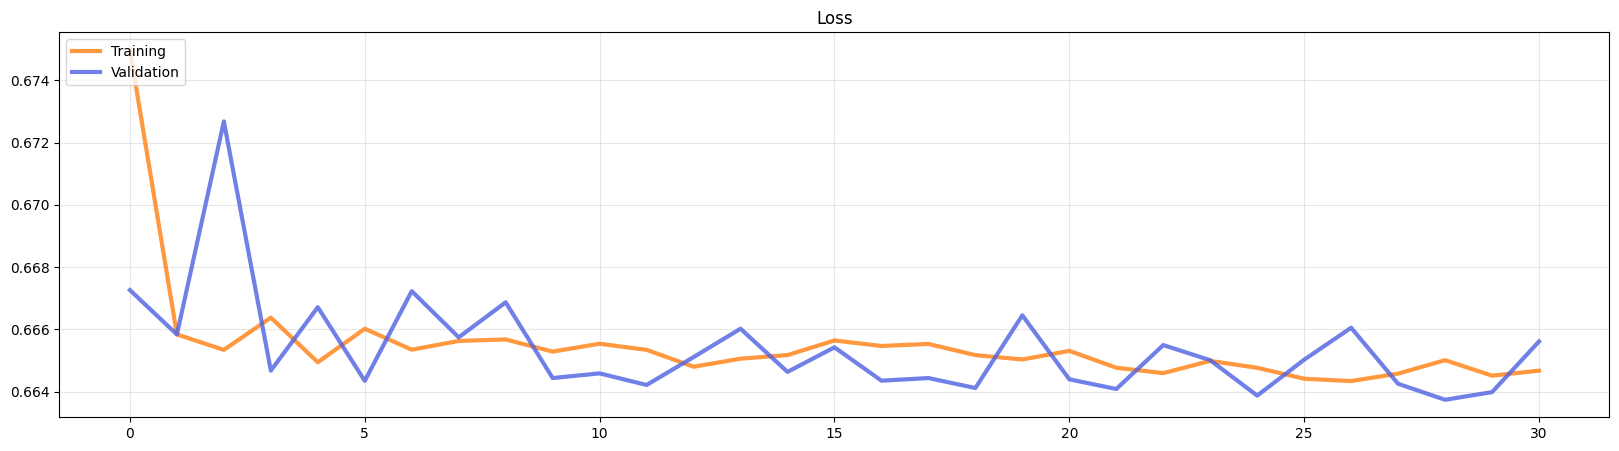

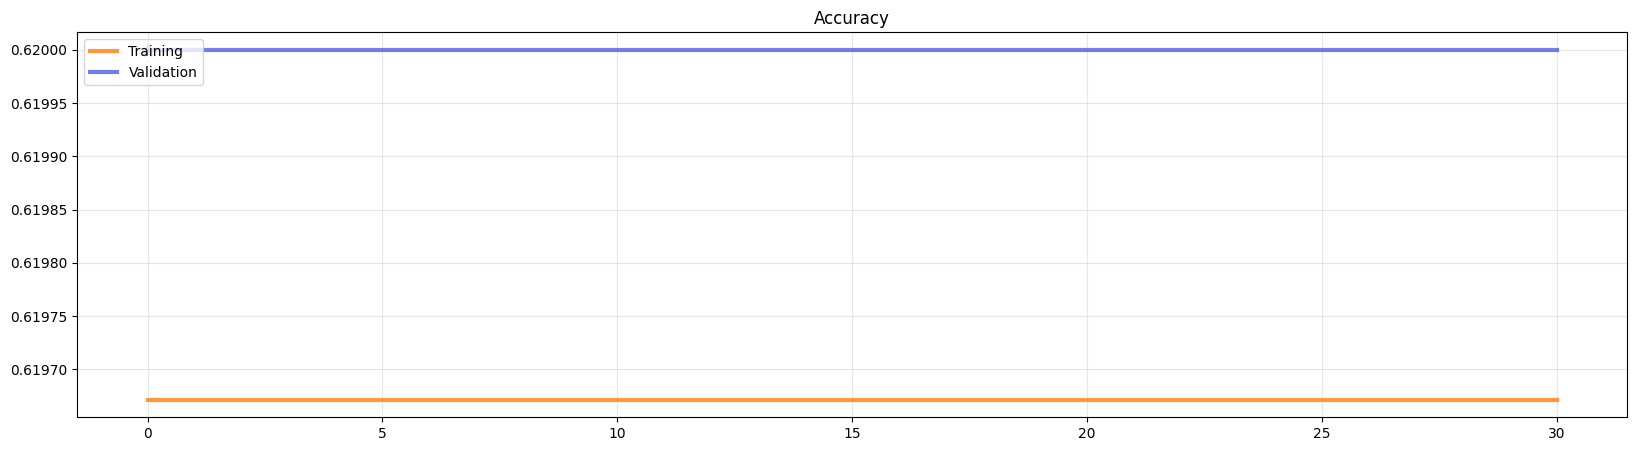

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
model_1.save('mobilenetv2_NO_INVERSION_nobatchnorm')
del model_1

In [ ]:
ft_model = tfk.models.load_model('mobilenetv2_NO_INVERSION_nobatchnorm')

In [ ]:
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
ft_model.get_layer('mobilenetv2_1.00_96').summary()

In [ ]:
# Freeze up to last N layers
N = 7    # last block
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:-N]):
  layer.trainable=False

In [ ]:
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
  print(layer.name, layer.trainable)

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics='accuracy')

In [ ]:
history = ft_model.fit(
    x = tfk.applications.xception.preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 400,
    validation_data = (tfk.applications.xception.preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.9, patience = 8, min_lr = 2e-6)
    ]
).history

In [ ]:
ft_model.save('mobilenetv2_NO_INVERSION_finetuned')
del ft_model